# Assign RegulatoryOverlayUUIDs Values to Water Right Sites.csv
- Purpose:  To assign RegulatoryOverlayUUIDs values to state water right sites.csv File.
- Note: requires the completed pre-processed sites.csv file from the state "WaterAllocation/ProcessedInputData" folder to be copied over to the "Regulatory/ProcessedInputData" folder.

In [1]:
# Needed Libraries / Modules

# ---- working with data ----
import os  # native operating system interaction
import numpy as np  # mathematical array manipulation
import pandas as pd  # data structure and data analysis
import geopandas as gpd  # geo-data structure and data analysis

# ---- visualization ----
import matplotlib.pyplot as plt  # plotting library
import seaborn as sns  # plotting library
import geoplot as gplt # for plotting maps
import geoplot.crs as gcrs #used to pull in webdata

# ---- API data retrieval ----
import requests  # http requests
import json  # JSON parse

# ---- Cleanup ----
import re  # string regular expression manipulation
from datetime import datetime  # date and time manipulation
pd.set_option('display.max_columns', 999)  # How to display all columns of a Pandas DataFrame in Jupyter Notebook
pd.set_option('display.float_format', lambda x: '%.5f' % x)  # suppress scientific notation in Pandas

In [2]:
# ---- working directory ----
workingDirString = "G:/Shared drives/WaDE Data/NewMexico/Regulatory" # set working directory folder string here
os.chdir(workingDirString)
print(f'The working Directory is:', workingDirString)

The working Directory is: G:/Shared drives/WaDE Data/NewMexico/Regulatory


## Input Data

In [3]:
# Regulatory Input Data
dfro = pd.read_csv("ProcessedInputData/regulatoryoverlays.csv")
dfru = pd.read_csv("ProcessedInputData/reportingunits.csv")
dfrru = pd.read_csv("ProcessedInputData/regulatoryreportingunits.csv")

# Water right Input Data
dfws = pd.read_csv('ProcessedInputData/wr_watersources.csv')
dfs = pd.read_csv('ProcessedInputData/wr_sites.csv')

#### regulatory watersource info with reporting unit info

In [4]:
# merge regulatoryoverlays -to- regulatoryreportingunits -to- reportingunits
dfro = pd.merge(dfro[['RegulatoryOverlayUUID', 'WaterSourceTypeCV']], dfrru[['RegulatoryOverlayUUID', 'ReportingUnitUUID']], left_on='RegulatoryOverlayUUID', right_on='RegulatoryOverlayUUID', how='left')
dfru = pd.merge(dfru, dfro, left_on='ReportingUnitUUID', right_on='ReportingUnitUUID', how='left')

print(dfru['WaterSourceTypeCV'].unique()) # check WaterSourceTypeCV for unique values for
print(len(dfru))
dfru.head(1)

['Surface Water' 'Surface Water and Groundwater']
206


ReportingUnitUUID  EPSGCodeCV  \
0      NMre_RUISCR0        4326   

                                ReportingUnitName ReportingUnitNativeID  \
0  McGaffey and Main Ground Water Management Area                 ISCR0   

   ReportingUnitProductVersion       ReportingUnitTypeCV  \
0                          NaN  Interstate River Compact   

   ReportingUnitUpdateDate StateCV  \
0                      NaN      NM   

                                            Geometry RegulatoryOverlayUUID  \
0  POLYGON ((-105.50932300135537 36.9959380014376...          NMre_ROISCR0   

  WaterSourceTypeCV  
0     Surface Water

#### water right watersource info with site info

In [5]:
#### water right watersource info with site info

# explode site.csv on WaterSourceUUIDs
dfs = dfs.assign(WaterSourceUUIDs=dfs['WaterSourceUUIDs'].str.split(',')).explode('WaterSourceUUIDs').reset_index(drop=True)

# merge watersources to dfs via WaterSourceUUIDs -to -WaterSourceUUID
dfs = pd.merge(dfs, dfws[['WaterSourceUUID', 'WaterSourceTypeCV']], left_on='WaterSourceUUIDs', right_on='WaterSourceUUID', how='left')
print(dfs['WaterSourceTypeCV'].unique()) # check WaterSourceTypeCV for unique values for
print(len(dfs))
dfs.head(1)

['Groundwater' 'WaDE Blank' 'Surface and Groundwater' 'Surface Water']
265649


SiteUUID  RegulatoryOverlayUUIDs WaterSourceUUIDs CoordinateAccuracy  \
0  NMwr_SA00001                     NaN   NMwr_WSwadeID1   WaDE Unspecified   

  CoordinateMethodCV   County  EPSGCodeCV  Geometry  GNISCodeCV  HUC12  HUC8  \
0   WaDE Unspecified  Hidalgo        4326       NaN         NaN    NaN   NaN   

   Latitude  Longitude  NHDNetworkStatusCV  NHDProductCV PODorPOUSite  \
0  32.08853 -108.88052                 NaN           NaN          POD   

     SiteName SiteNativeID  SitePoint        SiteTypeCV StateCV  USGSSiteID  \
0  WaDE Blank      A-00001        NaN  WaDE Unspecified      NM         NaN   

  WaterSourceUUID WaterSourceTypeCV  
0  NMwr_WSwadeID1       Groundwater

# Extract RegulatoryOverlay from Reporting Units and assing to WR Sites

#### Interstate Stream Compact Regions

In [6]:
# Create copy of reportingunits dataframe
# Extract out ReportingUnitTypeCV from reportingunits dataframe
# note unique WaterSourceTypeCV
dfru_iscr = dfru.copy()
dfru_iscr = dfru_iscr[dfru_iscr['ReportingUnitTypeCV'] == 'Interstate River Compact']
print(len(dfru_iscr))
print(dfru_iscr['WaterSourceTypeCV'].unique())
dfru_iscr.head(1)

8
['Surface Water']


ReportingUnitUUID  EPSGCodeCV  \
0      NMre_RUISCR0        4326   

                                ReportingUnitName ReportingUnitNativeID  \
0  McGaffey and Main Ground Water Management Area                 ISCR0   

   ReportingUnitProductVersion       ReportingUnitTypeCV  \
0                          NaN  Interstate River Compact   

   ReportingUnitUpdateDate StateCV  \
0                      NaN      NM   

                                            Geometry RegulatoryOverlayUUID  \
0  POLYGON ((-105.50932300135537 36.9959380014376...          NMre_ROISCR0   

  WaterSourceTypeCV  
0     Surface Water

In [7]:
# Convert extracted reportingunits dataframe -to- geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

dfru_iscr = dfru_iscr[dfru_iscr['Geometry'] != ""].reset_index(drop=True)
dfru_iscr['Geometry'] = gpd.GeoSeries.from_wkt(dfru_iscr['Geometry'], crs="EPSG:4326")
gdfru_iscr = gpd.GeoDataFrame(dfru_iscr, geometry=dfru_iscr['Geometry'], crs="EPSG:4326") # covert to geodataframe
#gdf_iscr['Geometry'] = gdf_iscr.simplify(0.001) # simplify the geometry. Lower the number the larger the exported file.
gplt.polyplot(gdfru_iscr, ax=ax)

<GeoAxesSubplot: >

In [8]:
# Create copy of water right sites dataframe
# Extract out WaterSourceTypeCV and match to that of above reportingunits dataframe
dfs_iscr = dfs.copy()
dfs_iscr = dfs_iscr[dfs_iscr['WaterSourceTypeCV'] != 'Groundwater']
print(len(dfs_iscr))
print(dfs_iscr['WaterSourceTypeCV'].unique())
dfs_iscr.head(1)

86611
['WaDE Blank' 'Surface and Groundwater' 'Surface Water']


SiteUUID  RegulatoryOverlayUUIDs WaterSourceUUIDs CoordinateAccuracy  \
13  NMwr_SA00005B                     NaN   NMwr_WSwadeID2   WaDE Unspecified   

   CoordinateMethodCV   County  EPSGCodeCV  Geometry  GNISCodeCV  HUC12  HUC8  \
13   WaDE Unspecified  Hidalgo        4326       NaN         NaN    NaN   NaN   

    Latitude  Longitude  NHDNetworkStatusCV  NHDProductCV PODorPOUSite  \
13  32.06669 -108.86542                 NaN           NaN          POD   

      SiteName SiteNativeID  SitePoint        SiteTypeCV StateCV  USGSSiteID  \
13  WaDE Blank    A-00005-B        NaN  WaDE Unspecified      NM         NaN   

   WaterSourceUUID WaterSourceTypeCV  
13  NMwr_WSwadeID2        WaDE Blank

In [9]:
# Convert extracted water right sites -to- geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

gdfs_iscr = gpd.GeoDataFrame(dfs_iscr, geometry=gpd.points_from_xy(dfs_iscr.Longitude.astype(float), dfs_iscr.Latitude.astype(float)), crs="EPSG:4326")
gplt.pointplot(gdfs_iscr, hue='PODorPOUSite', legend=True, legend_var='hue', ax=ax)

<GeoAxesSubplot: >

In [10]:
# Select water rights sites within extracted reportingunits polygon.
gdfs_iscr = gpd.sjoin(left_df=gdfs_iscr, right_df=gdfru_iscr[['ReportingUnitUUID', 'RegulatoryOverlayUUID', 'geometry']], op='within').replace(np.nan, "")
print(len(gdfs_iscr))
gdfs_iscr.head(1)

C:\Users\rjame\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


65331


SiteUUID RegulatoryOverlayUUIDs WaterSourceUUIDs CoordinateAccuracy  \
13  NMwr_SA00005B                          NMwr_WSwadeID2   WaDE Unspecified   

   CoordinateMethodCV   County  EPSGCodeCV Geometry GNISCodeCV HUC12 HUC8  \
13   WaDE Unspecified  Hidalgo        4326                                  

    Latitude  Longitude NHDNetworkStatusCV NHDProductCV PODorPOUSite  \
13  32.06669 -108.86542                                          POD   

      SiteName SiteNativeID SitePoint        SiteTypeCV StateCV USGSSiteID  \
13  WaDE Blank    A-00005-B            WaDE Unspecified      NM              

   WaterSourceUUID WaterSourceTypeCV                     geometry  \
13  NMwr_WSwadeID2        WaDE Blank  POINT (-108.86542 32.06669)   

    index_right ReportingUnitUUID RegulatoryOverlayUUID  
13            7      NMre_RUISCR7          NMre_ROISCR7

<GeoAxesSubplot: >

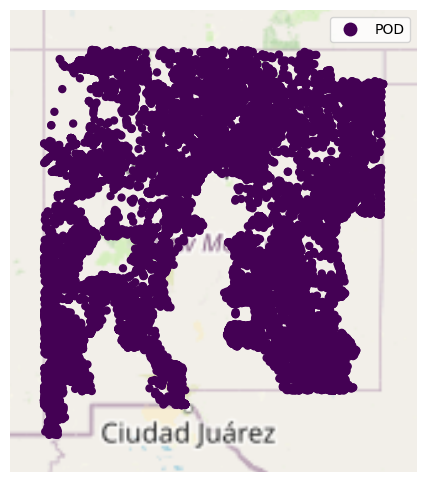

In [11]:
# plot the selected points
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot
gplt.pointplot(gdfs_iscr, hue='PODorPOUSite', legend=True, legend_var='hue', ax=ax)

In [12]:
# set RegulatoryOverlayUUIDs
gdfs_iscr['RegulatoryOverlayUUIDs'] = gdfs_iscr['RegulatoryOverlayUUID']
gdfs_iscr = gdfs_iscr.drop(['RegulatoryOverlayUUID', 'geometry', 'index_right', 'ReportingUnitUUID'], axis=1)
gdfs_iscr.head(1)

SiteUUID RegulatoryOverlayUUIDs WaterSourceUUIDs CoordinateAccuracy  \
13  NMwr_SA00005B           NMre_ROISCR7   NMwr_WSwadeID2   WaDE Unspecified   

   CoordinateMethodCV   County  EPSGCodeCV Geometry GNISCodeCV HUC12 HUC8  \
13   WaDE Unspecified  Hidalgo        4326                                  

    Latitude  Longitude NHDNetworkStatusCV NHDProductCV PODorPOUSite  \
13  32.06669 -108.86542                                          POD   

      SiteName SiteNativeID SitePoint        SiteTypeCV StateCV USGSSiteID  \
13  WaDE Blank    A-00005-B            WaDE Unspecified      NM              

   WaterSourceUUID WaterSourceTypeCV  
13  NMwr_WSwadeID2        WaDE Blank

#### OSE Water Right District Boundary

In [13]:
# Create copy of reportingunits dataframe
# Extract out ReportingUnitTypeCV from reportingunits dataframe
# note unique WaterSourceTypeCV
dfru_osewrb = dfru.copy()
dfru_osewrb = dfru_osewrb[dfru_osewrb['ReportingUnitTypeCV'] == 'Water Rights District']
print(len(dfru_osewrb))
print(dfru_osewrb['WaterSourceTypeCV'].unique())
dfru_osewrb.head(1)

7
['Surface Water and Groundwater']


ReportingUnitUUID  EPSGCodeCV           ReportingUnitName  \
8    NMre_RUOSEWRB1        4326  Estancia Poor Quality Area   

  ReportingUnitNativeID  ReportingUnitProductVersion    ReportingUnitTypeCV  \
8               OSEWRB1                          NaN  Water Rights District   

   ReportingUnitUpdateDate StateCV  \
8                      NaN      NM   

                                            Geometry RegulatoryOverlayUUID  \
8  POLYGON ((-106.94996204701084 36.2032551785836...         NMre_ROOSEWR6   

               WaterSourceTypeCV  
8  Surface Water and Groundwater

In [14]:
# Convert to geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

dfru_osewrb = dfru_osewrb[dfru_osewrb['Geometry'] != ""].reset_index(drop=True)
dfru_osewrb['Geometry'] = gpd.GeoSeries.from_wkt(dfru_osewrb['Geometry'], crs="EPSG:4326")
gdfru_osewrb = gpd.GeoDataFrame(dfru_osewrb, geometry=dfru_osewrb['Geometry'], crs="EPSG:4326") # covert to geodataframe
#gdfru_osewrb['Geometry'] = gdfru_osewrb.simplify(0.001) # simplify the geometry. Lower the number the larger the exported file.
gplt.polyplot(gdfru_osewrb, ax=ax)

<GeoAxesSubplot: >

In [15]:
# Create copy of water right sites dataframe
# Extract out WaterSourceTypeCV and match to that of above reportingunits dataframe
dfs_osewrb = dfs.copy()
#dfs_osewrb = dfs_osewrb[dfs_osewrb['WaterSourceTypeCV'] != 'Groundwater']  # we are okay here, we want all rights related to Surfacewater and Groundwater
print(len(dfs_osewrb))
print(dfs_osewrb['WaterSourceTypeCV'].unique())
dfs_osewrb.head(1)

265649
['Groundwater' 'WaDE Blank' 'Surface and Groundwater' 'Surface Water']


SiteUUID  RegulatoryOverlayUUIDs WaterSourceUUIDs CoordinateAccuracy  \
0  NMwr_SA00001                     NaN   NMwr_WSwadeID1   WaDE Unspecified   

  CoordinateMethodCV   County  EPSGCodeCV  Geometry  GNISCodeCV  HUC12  HUC8  \
0   WaDE Unspecified  Hidalgo        4326       NaN         NaN    NaN   NaN   

   Latitude  Longitude  NHDNetworkStatusCV  NHDProductCV PODorPOUSite  \
0  32.08853 -108.88052                 NaN           NaN          POD   

     SiteName SiteNativeID  SitePoint        SiteTypeCV StateCV  USGSSiteID  \
0  WaDE Blank      A-00001        NaN  WaDE Unspecified      NM         NaN   

  WaterSourceUUID WaterSourceTypeCV  
0  NMwr_WSwadeID1       Groundwater

<GeoAxesSubplot: >

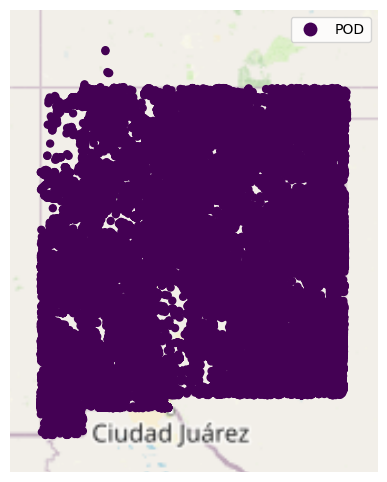

In [16]:
# Convert extracted water right sites -to- geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

gdfs_osewrb = gpd.GeoDataFrame(dfs_osewrb, geometry=gpd.points_from_xy(dfs_osewrb.Longitude.astype(float), dfs_osewrb.Latitude.astype(float)), crs="EPSG:4326")
gplt.pointplot(gdfs_osewrb, hue='PODorPOUSite', legend=True, legend_var='hue', ax=ax)

In [17]:
# Select sites within polygon.
gdfs_osewrb = gpd.sjoin(left_df=gdfs_osewrb, right_df=gdfru_osewrb[['ReportingUnitUUID', 'RegulatoryOverlayUUID', 'geometry']], op='within').replace(np.nan, "")
print(len(gdfs_osewrb))
gdfs_osewrb.head(1)

C:\Users\rjame\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


265596


SiteUUID RegulatoryOverlayUUIDs WaterSourceUUIDs CoordinateAccuracy  \
0  NMwr_SA00001                          NMwr_WSwadeID1   WaDE Unspecified   

  CoordinateMethodCV   County  EPSGCodeCV Geometry GNISCodeCV HUC12 HUC8  \
0   WaDE Unspecified  Hidalgo        4326                                  

   Latitude  Longitude NHDNetworkStatusCV NHDProductCV PODorPOUSite  \
0  32.08853 -108.88052                                          POD   

     SiteName SiteNativeID SitePoint        SiteTypeCV StateCV USGSSiteID  \
0  WaDE Blank      A-00001            WaDE Unspecified      NM              

  WaterSourceUUID WaterSourceTypeCV                     geometry  index_right  \
0  NMwr_WSwadeID1       Groundwater  POINT (-108.88052 32.08853)            2   

  ReportingUnitUUID RegulatoryOverlayUUID  
0    NMre_RUOSEWRB3         NMre_ROOSEWR4

In [18]:
# plot the selected points
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot
gplt.pointplot(gdfs_osewrb, hue='PODorPOUSite', legend=True, legend_var='hue', ax=ax)

<GeoAxesSubplot: >

In [19]:
# set RegulatoryOverlayUUIDs
gdfs_osewrb['RegulatoryOverlayUUIDs'] = gdfs_osewrb['RegulatoryOverlayUUID']
gdfs_osewrb = gdfs_osewrb.drop(['RegulatoryOverlayUUID', 'geometry', 'index_right', 'ReportingUnitUUID', 'WaterSourceUUID', 'WaterSourceTypeCV'], axis=1)
gdfs_osewrb.head(1)

SiteUUID RegulatoryOverlayUUIDs WaterSourceUUIDs CoordinateAccuracy  \
0  NMwr_SA00001          NMre_ROOSEWR4   NMwr_WSwadeID1   WaDE Unspecified   

  CoordinateMethodCV   County  EPSGCodeCV Geometry GNISCodeCV HUC12 HUC8  \
0   WaDE Unspecified  Hidalgo        4326                                  

   Latitude  Longitude NHDNetworkStatusCV NHDProductCV PODorPOUSite  \
0  32.08853 -108.88052                                          POD   

     SiteName SiteNativeID SitePoint        SiteTypeCV StateCV USGSSiteID  
0  WaDE Blank      A-00001            WaDE Unspecified      NM

#### Special Conditions Water Right

In [20]:
# Create copy of reportingunits dataframe
# Extract out ReportingUnitTypeCV from reportingunits dataframe
# note unique WaterSourceTypeCV
dfru_scwr = dfru.copy()
dfru_scwr = dfru_scwr[dfru_scwr['ReportingUnitTypeCV'] == 'Special Condition Water Right']
print(len(dfru_scwr))
print(dfru_scwr['WaterSourceTypeCV'].unique())
dfru_scwr.head(1)

191
['Surface Water and Groundwater']


ReportingUnitUUID  EPSGCodeCV  \
15      NMre_RUSCWR0        4326   

                                 ReportingUnitName ReportingUnitNativeID  \
15  McGaffey and Main Ground Water Management Area                 SCWR0   

    ReportingUnitProductVersion            ReportingUnitTypeCV  \
15                          NaN  Special Condition Water Right   

    ReportingUnitUpdateDate StateCV  \
15                      NaN      NM   

                                             Geometry RegulatoryOverlayUUID  \
15  POLYGON ((-104.50837499920681 33.3833663911460...          NMre_ROSCWR0   

                WaterSourceTypeCV  
15  Surface Water and Groundwater

In [21]:
# Convert to geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

dfru_scwr = dfru_scwr[dfru_scwr['Geometry'] != ""].reset_index(drop=True)
dfru_scwr['Geometry'] = gpd.GeoSeries.from_wkt(dfru_scwr['Geometry'], crs="EPSG:4326")
gdfru_scwr = gpd.GeoDataFrame(dfru_scwr, geometry=dfru_scwr['Geometry'], crs="EPSG:4326") # covert to geodataframe
#gdfru_scwr['Geometry'] = gdfru_scwr.simplify(0.001) # simplify the geometry. Lower the number the larger the exported file.
gplt.polyplot(gdfru_scwr, ax=ax)

<GeoAxesSubplot: >

In [22]:
# Create copy of water right sites dataframe
# Extract out WaterSourceTypeCV and match to that of above reportingunits dataframe
dfs_scwr = dfs.copy()
#dfs_scwr = dfs_scwr[dfs_scwr['WaterSourceTypeCV'] != 'Groundwater'] # we are okay here, we want all rights related to Surfacewater and Groundwater
print(len(dfs_scwr))
print(dfs_scwr['WaterSourceTypeCV'].unique())
dfs_scwr.head(1)

265649
['Groundwater' 'WaDE Blank' 'Surface and Groundwater' 'Surface Water']


SiteUUID  RegulatoryOverlayUUIDs WaterSourceUUIDs CoordinateAccuracy  \
0  NMwr_SA00001                     NaN   NMwr_WSwadeID1   WaDE Unspecified   

  CoordinateMethodCV   County  EPSGCodeCV  Geometry  GNISCodeCV  HUC12  HUC8  \
0   WaDE Unspecified  Hidalgo        4326       NaN         NaN    NaN   NaN   

   Latitude  Longitude  NHDNetworkStatusCV  NHDProductCV PODorPOUSite  \
0  32.08853 -108.88052                 NaN           NaN          POD   

     SiteName SiteNativeID  SitePoint        SiteTypeCV StateCV  USGSSiteID  \
0  WaDE Blank      A-00001        NaN  WaDE Unspecified      NM         NaN   

  WaterSourceUUID WaterSourceTypeCV  
0  NMwr_WSwadeID1       Groundwater

<GeoAxesSubplot: >

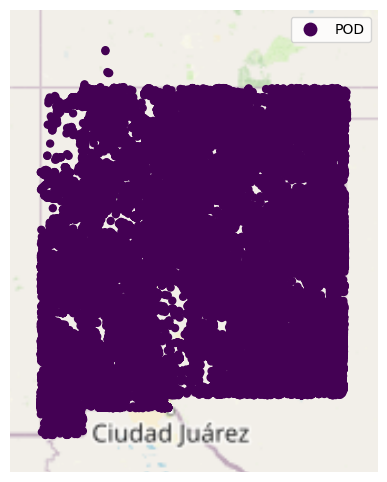

In [23]:
# Convert extracted water right sites -to- geodataframe & plot
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot

gdfs_scwr = gpd.GeoDataFrame(dfs_scwr, geometry=gpd.points_from_xy(dfs_scwr.Longitude.astype(float), dfs_scwr.Latitude.astype(float)), crs="EPSG:4326")
gplt.pointplot(gdfs_scwr, hue='PODorPOUSite', legend=True, legend_var='hue', ax=ax)

In [24]:
# Select water rights sites within extracted reportingunits polygon.
gdfs_scwr = gpd.sjoin(left_df=gdfs_scwr, right_df=gdfru_scwr[['ReportingUnitUUID', 'RegulatoryOverlayUUID', 'geometry']], op='within').replace(np.nan, "")
print(len(gdfs_scwr))
gdfs_scwr.head(1)

C:\Users\rjame\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


167015


SiteUUID RegulatoryOverlayUUIDs WaterSourceUUIDs CoordinateAccuracy  \
0  NMwr_SA00001                          NMwr_WSwadeID1   WaDE Unspecified   

  CoordinateMethodCV   County  EPSGCodeCV Geometry GNISCodeCV HUC12 HUC8  \
0   WaDE Unspecified  Hidalgo        4326                                  

   Latitude  Longitude NHDNetworkStatusCV NHDProductCV PODorPOUSite  \
0  32.08853 -108.88052                                          POD   

     SiteName SiteNativeID SitePoint        SiteTypeCV StateCV USGSSiteID  \
0  WaDE Blank      A-00001            WaDE Unspecified      NM              

  WaterSourceUUID WaterSourceTypeCV                     geometry  index_right  \
0  NMwr_WSwadeID1       Groundwater  POINT (-108.88052 32.08853)          142   

  ReportingUnitUUID RegulatoryOverlayUUID  
0     NMre_RUSCWR55         NMre_ROSCWR55

<GeoAxesSubplot: >

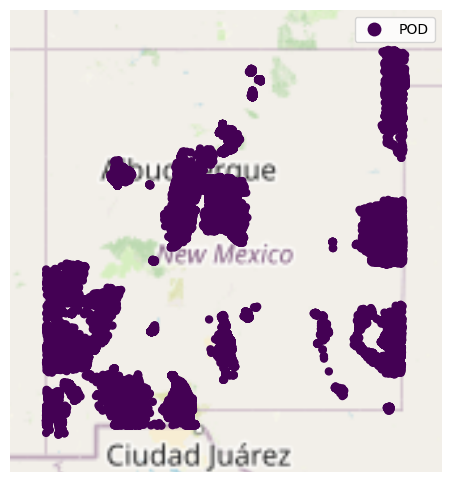

In [25]:
# plot the selected points
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa')) # use for background map in subplot
ax = gplt.webmap(contiguous_usa, projection=gcrs.WebMercator()) # set subplot
gplt.pointplot(gdfs_scwr, hue='PODorPOUSite', legend=True, legend_var='hue', ax=ax)

In [26]:
# set RegulatoryOverlayUUIDs
gdfs_scwr['RegulatoryOverlayUUIDs'] = gdfs_scwr['RegulatoryOverlayUUID']
gdfs_scwr = gdfs_scwr.drop(['RegulatoryOverlayUUID', 'geometry', 'index_right', 'ReportingUnitUUID', 'WaterSourceUUID', 'WaterSourceTypeCV'], axis=1)
gdfs_scwr.head(1)

SiteUUID RegulatoryOverlayUUIDs WaterSourceUUIDs CoordinateAccuracy  \
0  NMwr_SA00001          NMre_ROSCWR55   NMwr_WSwadeID1   WaDE Unspecified   

  CoordinateMethodCV   County  EPSGCodeCV Geometry GNISCodeCV HUC12 HUC8  \
0   WaDE Unspecified  Hidalgo        4326                                  

   Latitude  Longitude NHDNetworkStatusCV NHDProductCV PODorPOUSite  \
0  32.08853 -108.88052                                          POD   

     SiteName SiteNativeID SitePoint        SiteTypeCV StateCV USGSSiteID  
0  WaDE Blank      A-00001            WaDE Unspecified      NM

## Concatenate all Regulatory Area Data Types together
- drop geometry from the wade wr sites.csv geodataframe

In [27]:
# Concatenate dataframes into single output
frames = [dfs, gdfs_iscr, gdfs_osewrb, gdfs_scwr] # list all out dataframes here
outdfs = pd.concat(frames)
outdfs = outdfs.drop_duplicates().reset_index(drop=True).replace(np.nan, "")
outdfs = outdfs.groupby('SiteUUID').agg(lambda x: ','.join([str(elem) for elem in (list(set(x))) if elem != ""])).replace(np.nan, "").reset_index()
print(len(outdfs))
outdfs.head(1)

265649


SiteUUID                     RegulatoryOverlayUUIDs WaterSourceUUIDs  \
0  NMwr_SA00001  NMre_ROSCWR55,NMre_ROOSEWR4,NMre_ROSCWR60   NMwr_WSwadeID1   

  CoordinateAccuracy CoordinateMethodCV   County EPSGCodeCV Geometry  \
0   WaDE Unspecified   WaDE Unspecified  Hidalgo       4326            

  GNISCodeCV HUC12 HUC8           Latitude            Longitude  \
0                        32.08852543145729  -108.88051896223872   

  NHDNetworkStatusCV NHDProductCV PODorPOUSite    SiteName SiteNativeID  \
0                                          POD  WaDE Blank      A-00001   

  SitePoint        SiteTypeCV StateCV USGSSiteID WaterSourceUUID  \
0            WaDE Unspecified      NM             NMwr_WSwadeID1   

  WaterSourceTypeCV  
0       Groundwater

# Inspect Output Data & Export

In [29]:
outdfs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265649 entries, 0 to 265648
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   SiteUUID                265649 non-null  object
 1   RegulatoryOverlayUUIDs  265649 non-null  object
 2   WaterSourceUUIDs        265649 non-null  object
 3   CoordinateAccuracy      265649 non-null  object
 4   CoordinateMethodCV      265649 non-null  object
 5   County                  265649 non-null  object
 6   EPSGCodeCV              265649 non-null  object
 7   Geometry                265649 non-null  object
 8   GNISCodeCV              265649 non-null  object
 9   HUC12                   265649 non-null  object
 10  HUC8                    265649 non-null  object
 11  Latitude                265649 non-null  object
 12  Longitude               265649 non-null  object
 13  NHDNetworkStatusCV      265649 non-null  object
 14  NHDProductCV            265649 non-n

In [30]:
outdfs

SiteUUID                     RegulatoryOverlayUUIDs  \
0            NMwr_SA00001  NMre_ROSCWR55,NMre_ROOSEWR4,NMre_ROSCWR60   
1           NMwr_SA00001S  NMre_ROSCWR55,NMre_ROOSEWR4,NMre_ROSCWR60   
2          NMwr_SA00001S2  NMre_ROSCWR55,NMre_ROOSEWR4,NMre_ROSCWR60   
3            NMwr_SA00002  NMre_ROSCWR55,NMre_ROOSEWR4,NMre_ROSCWR60   
4           NMwr_SA00002S  NMre_ROSCWR55,NMre_ROOSEWR4,NMre_ROSCWR60   
...                   ...                                        ...   
265644  NMwr_SVV00198POD1                NMre_ROOSEWR4,NMre_ROSCWR37   
265645  NMwr_SVV00199POD1   NMre_ROOSEWR4,NMre_ROISCR7,NMre_ROSCWR37   
265646  NMwr_SVV00200POD1                NMre_ROOSEWR4,NMre_ROSCWR37   
265647  NMwr_SVV00201POD1   NMre_ROOSEWR4,NMre_ROISCR7,NMre_ROSCWR37   
265648   NMwr_SY00001POD1                 NMre_ROOSEWR4,NMre_ROISCR7   

       WaterSourceUUIDs CoordinateAccuracy CoordinateMethodCV   County  \
0        NMwr_WSwadeID1   WaDE Unspecified   WaDE Unspecified  Hidalgo   
1        NMwr_WSwadeID1   WaDE Unspecified   WaDE Unspecified  Hidalgo   
2        NMwr_WSwadeID1   WaDE Unspecified   WaDE Unspecified  Hidalgo   
3        NMwr_WSwadeID1   WaDE Unspecified   WaDE Unspecified  Hidalgo   
4        NMwr_WSwadeID1   WaDE Unspecified   WaDE Unspecified  Hidalgo   
...                 ...                ...                ...      ...   
265644   NMwr_WSwadeID1   WaDE Unspecified   WaDE Unspecified  Hidalgo   
265645   NMwr_WSwadeID2   WaDE Unspecified   WaDE Unspecified  Hidalgo   
265646   NMwr_WSwadeID1   WaDE Unspecified   WaDE Unspecified  Hidalgo   
265647   NMwr_WSwadeID2   WaDE Unspecified   WaDE Unspecified  Hidalgo   
265648   NMwr_WSwadeID2   WaDE Unspecified   WaDE Unspecified  Hidalgo   

       EPSGCodeCV Geometry GNISCodeCV HUC12 HUC8           Latitude  \
0            4326                                 32.08852543145729   
1            4326                                 32.08880863623688   
2            4326                                 32.08894715341991   
3            4326                                 32.23971296437374   
4            4326                                 32.23562412371736   
...           ...      ...        ...   ...  ...                ...   
265644       4326                                 32.69541658839018   
265645       4326                                 32.68716662119876   
265646       4326                                 32.69444481184614   
265647       4326                                 32.69353629696729   
265648       4326                                 31.38299963564629   

                  Longitude NHDNetworkStatusCV NHDProductCV PODorPOUSite  \
0       -108.88051896223872                                          POD   
1       -108.88089406970218                                          POD   
2        -108.8807855981426                                          POD   
3        -108.8457832111845                                          POD   
4       -108.84559903738057                                          POD   
...                     ...                ...          ...          ...   
265644  -109.02172178459696                                          POD   
265645  -108.99855516895518                                          POD   
265646  -109.03749974324502                                          POD   
265647   -109.0247385440764                                          POD   
265648   -109.0244717758394                                          POD   

          SiteName   SiteNativeID SitePoint        SiteTypeCV StateCV  \
0       WaDE Blank        A-00001            WaDE Unspecified      NM   
1       WaDE Blank      A-00001-S            WaDE Unspecified      NM   
2       WaDE Blank     A-00001-S2            WaDE Unspecified      NM   
3       WaDE Blank        A-00002            WaDE Unspecified      NM   
4       WaDE Blank      A-00002-S            WaDE Unspecified      NM   
...            ...            ...       ...               .

In [31]:
outdfs.to_csv('ProcessedInputData/sites.csv', index=False) # this is in the Regulatory data folder